<h2>Part 3 - corralation</h2>
<p>
In this part we are going to add the housing value.
Tying to understand if this data has any correlation to the number of resturant around
or to any type of resturant.
<br/>
to explore this we will start by spliting the data into test and split.
our target variable is the price.
<br/>
Then using linar regression to check two scenarios, first a correlation between the params and the prices
    secondly a correlation between the number of resturant in a zip code and the prices.
    To reacher or poorarer locations has more or less resturants?
</p>

In [1]:
import numpy as np
import pandas as pd

# import plotting libraries to explore the data
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex
import seaborn as sns;

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# for testing
from datetime import datetime

In [2]:
# import CSV
dummies = pd.read_csv('dummies.csv')
zipcodes_df = pd.read_csv('grouped_zipcodes.csv')

print('dummies shape: ', dummies.shape)
print('ZipCode shape: ', zipcodes_df.shape)

dummies shape:  (151065, 184)
ZipCode shape:  (29994, 7)


In [3]:
zipcodes_df.head()

,Unnamed: 0,Zip,City,State,Latitude,Longitude,House Value
0,0,66025,Eudora,KS,38.917032,-95.06455,208694.0
1,1,74565,Savanna,OK,34.831398,-95.83967,68095.0
2,2,75631,Beckville,TX,32.237924,-94.46427,159363.0
3,3,92067,Rancho Santa Fe,CA,33.016492,-117.20264,2820030.0
4,4,92119,San Diego,CA,32.802250,-117.02431,675483.0


In [4]:
list_categories = dummies.columns[1:]

In [5]:
# group by zip codes
temp = zipcodes_df[['Zip', 'State', 'House Value']]

resturants_grouped = dummies.groupby('ZipCode').sum().reset_index()


# add sum as number of resturants in each zip code
resturants_grouped["Total Restaurants"] = resturants_grouped.drop(columns=['ZipCode']).sum(axis=1)

resturants_grouped = pd.merge(left=resturants_grouped, right=temp, how='left', left_on='ZipCode', right_on='Zip')

resturants_grouped.dropna(inplace=True)
# let drop all but resturnat type, zip code and house values
resturants_grouped = resturants_grouped.drop(columns=['Zip'])

resturants_grouped

,ZipCode,Afghan Restaurant,African Restaurant,American Restaurant,Andhra Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,...,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Total Restaurants,State,House Value
0,501,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,NY,172372.0
2,1001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,MA,236595.0
3,1002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,22,MA,372334.0
4,1003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,MA,255478.0
6,1005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,MA,267895.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7839,96145,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,35,CA,963341.0
7840,96146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,CA,762962.0
7841,96148,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,CA,645649.0
7842,96150,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,30,CA,513620.0


In [6]:
# removes null rows
print('DF before null removal ', len(resturants_grouped))
resturants_grouped = resturants_grouped[~resturants_grouped['House Value'].isnull()]
print('DF after null removal ', len(resturants_grouped))

DF before null removal  5505
DF after null removal  5505


In [7]:
# use the groped df to create variables for regression
non_res_col = ['ZipCode', 'State', 'House Value', 'Total Restaurants']
feature_col = resturants_grouped.columns.drop(non_res_col)
y = resturants_grouped['House Value'].to_numpy() / 1000
x = resturants_grouped[feature_col].to_numpy()

<h3>Step 2: Linear regression</h3>

In [8]:
## define a function to run linar regrssion
## will keep the information consistent

# function to split train test and two transformation on X values
def split_x_y(X, Y):
    from sklearn.preprocessing import StandardScaler
    
    # split to trai and test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

    #standardization scaler 
    s_scaler = StandardScaler()
    X_train = s_scaler.fit_transform(X_train.astype(np.float))
    X_test = s_scaler.transform(X_test.astype(np.float))

    print('Train size ({}, {})'.format(X_train.shape, y_train.shape))
    print('Test size ({}, {})'.format(X_test.shape, y_test.shape))
    
    return X_train, X_test, y_train, y_test

# simple linar regression using feature to explain house price
def run_linear_reg(X, Y, f_col):
    
    X_train, X_test, y_train, y_test = split_x_y(X, Y)
    # run regression
    
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)

    #predicting the test set result
    y_pred = regressor.predict(X_test)

    #evaluate the model (intercept and slope)
    print('intercept: ', regressor.intercept_)
    regressor.score(X_test, y_test)
    
    cv_score = get_cv_scores(regressor, X_train, y_train)
    msq, r_2 = scoring(y_test, y_pred, cv_score)
    
    #put results as a DataFrame
    coeff_df = pd.DataFrame(regressor.coef_, f_col, columns=['Coefficient']) 

    return coeff_df, [msq, r_2, cv_score]

def get_cv_scores(model, Xtrain, ytrain):
    # Importing cross_val_score function from the model_selection submodule of scikit learn
    from sklearn.model_selection import cross_val_score
    # storing the ten scores in an object called mse
    mse= cross_val_score(model,Xtrain,ytrain, scoring='neg_mean_squared_error',cv=10)
    # taking the mean of mse for using as an indicator of how good the model is
    return mse.mean()

# define a scoring function to use
def scoring(y_test, y_pred, cv_score):
    # calculate values
    r_2 = metrics.r2_score(y_test, y_pred)
    msq = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    # print values
    print('mean squared error(sqrt): ', msq)
    print('R**2; ', r_2)
    print('CV score; ', cv_score)
    # return values in array
    return [msq, r_2]

In [9]:
coeff_df, basic_result = run_linear_reg(x, y, feature_col)
coeff_df.insert(0, 'Model', ['Linear' for _ in range(len(coeff_df))])

Train size ((3688, 183), (3688,))
Test size ((1817, 183), (1817,))
intercept:  417.8795848698481
mean squared error(sqrt):  329.74219926681127
R**2;  0.25704460919652394
CV score;  -148859.97872803928


In [10]:
# print the top 10 coeff and the botton 10
coeff_df.sort_values(by='Coefficient', ascending=False).head(10)

,Model,Coefficient
Coffee Shop,Linear,60.352714
Juice Bar,Linear,50.076883
Food Truck,Linear,43.007697
Sushi Restaurant,Linear,40.065604
New American Restaurant,Linear,34.025771
Italian Restaurant,Linear,31.938158
Japanese Restaurant,Linear,29.992101
Churrascaria,Linear,27.791999
French Restaurant,Linear,26.489033
Mediterranean Restaurant,Linear,26.155944


In [11]:
coeff_df.sort_values(by='Coefficient', ascending=True).head(10)

,Model,Coefficient
Fair,Linear,-9.693529e+13
Fast Food Restaurant,Linear,-3.686293e+01
Pizza Place,Linear,-3.565448e+01
Southern / Soul Food Restaurant,Linear,-2.849214e+01
American Restaurant,Linear,-2.265395e+01
Diner,Linear,-2.047226e+01
Bar,Linear,-1.888890e+01
Sandwich Place,Linear,-1.823307e+01
Food Court,Linear,-1.769918e+01
Steakhouse,Linear,-1.767865e+01


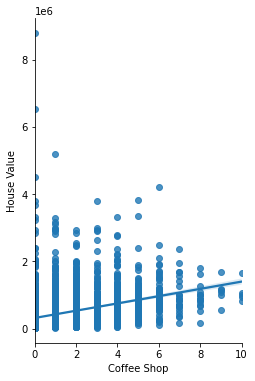

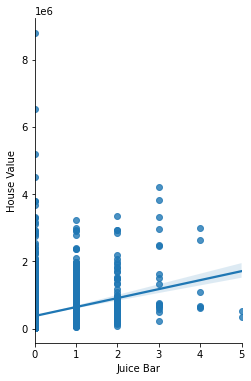

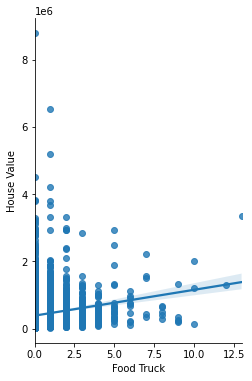

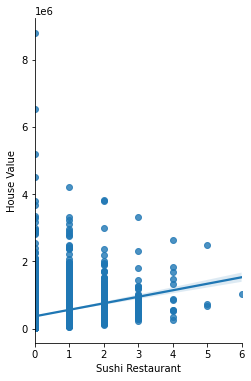

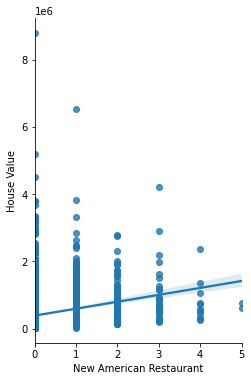

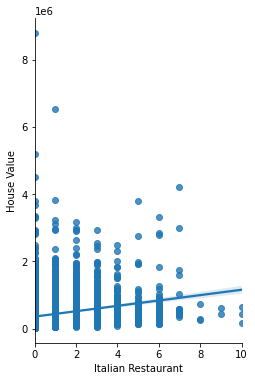

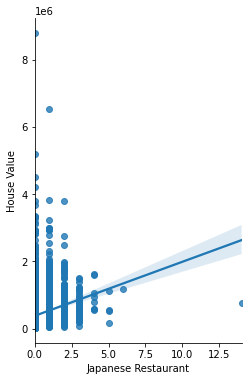

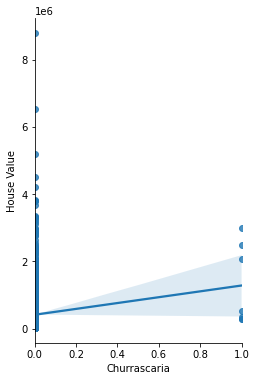

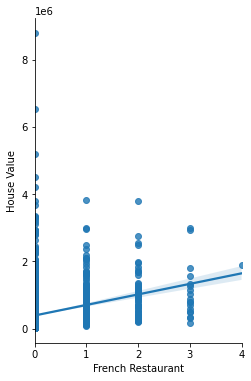

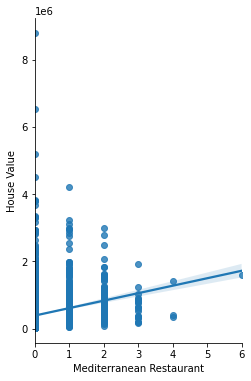

In [12]:
# we can plot a graph of the top 10 coeff, and check how the data is spread
coef_test = coeff_df.sort_values(by='Coefficient', ascending=False).head(10)

for idx, coef in enumerate(coef_test.index.values):
    # plot fast food data agains price
    sns.pairplot(resturants_grouped,
             x_vars=[coef], 
             y_vars='House Value', 
             height=5,
             aspect=0.7, 
             kind='reg')

<h5>Feature selection for regression:</h5>
<p>Seince our model is huge lets select a sample of the feaures using two scorring algorithems, mutual_info_regression and f_regression
eventually most of them will overlap and we can select the unique values of the combined list</p>

In [13]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# run train set on full dataset
X_train, X_test, y_train, y_test = split_x_y(x,y)

# feature selection
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# transform train input data
X_train_fs = f_selector.transform(X_train)
# transform test input data
X_test_fs = f_selector.transform(X_test)

# finding which features scored above the score mean + 1std or more on the mutual information
mir_feaures = feature_col[f_selector.scores_ > (f_selector.scores_.mean() + f_selector.scores_.std())]
mir_feaures

Train size ((3688, 183), (3688,))
Test size ((1817, 183), (1817,))


Index(['Asian Restaurant', 'Bagel Shop', 'Bakery', 'Bubble Tea Shop',
       'Burger Joint', 'Café', 'Chinese Restaurant', 'Coffee Shop',
       'Deli / Bodega', 'Donut Shop', 'French Restaurant',
       'Italian Restaurant', 'Japanese Restaurant', 'Juice Bar',
       'Mediterranean Restaurant', 'Mexican Restaurant',
       'New American Restaurant', 'Pizza Place', 'Sushi Restaurant',
       'Thai Restaurant'],
      dtype='object')

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression

# run train set on full dataset
X_train, X_test, y_train, y_test = split_x_y(x,y)

# feature selection
f_selector = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# transform train input data
X_train_fs = f_selector.transform(X_train)
# transform test input data
X_test_fs = f_selector.transform(X_test)
# finding relevant features

non_nan =  np.nan_to_num(f_selector.scores_, 0)
fr_features = feature_col[non_nan > (non_nan.mean() + non_nan.std())]
fr_features

Train size ((3688, 183), (3688,))
Test size ((1817, 183), (1817,))


/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Index(['Bagel Shop', 'Bakery', 'Bubble Tea Shop', 'Burger Joint', 'Café',
       'Coffee Shop', 'French Restaurant', 'Italian Restaurant',
       'Japanese Restaurant', 'Juice Bar', 'Mediterranean Restaurant',
       'Mexican Restaurant', 'New American Restaurant', 'Salad Place',
       'Sushi Restaurant', 'Thai Restaurant'],
      dtype='object')

In [15]:
# combine both feature to array and remove duplicated
short_feature_list = [*mir_feaures.values, *fr_features.values]
short_feature_list = np.unique(short_feature_list)
print('# of features ', len(short_feature_list))

# of features  21


In [16]:
print (', '.join(short_feature_list))

Asian Restaurant, Bagel Shop, Bakery, Bubble Tea Shop, Burger Joint, Café, Chinese Restaurant, Coffee Shop, Deli / Bodega, Donut Shop, French Restaurant, Italian Restaurant, Japanese Restaurant, Juice Bar, Mediterranean Restaurant, Mexican Restaurant, New American Restaurant, Pizza Place, Salad Place, Sushi Restaurant, Thai Restaurant


In [17]:
# create new features just with those values
x_new = resturants_grouped[short_feature_list].to_numpy()
coeff_sel_df, selected_fe_result = run_linear_reg(x_new, y, short_feature_list)

coeff_sel_df.insert(0, 'Model', ['Linear-Selected' for _ in range(len(coeff_sel_df))])

Train size ((3688, 21), (3688,))
Test size ((1817, 21), (1817,))
intercept:  417.87958486984814
mean squared error(sqrt):  333.6161614619234
R**2;  0.23948490226712515
CV score;  -147886.8403825623


<h3>Polynomil Regresion</h3>
<p>Polynomial regression is just another case of linear regression but the data is converted to polynomical degree
<br/>
for this test I'll use the smaller sample size we already selected from the linear reg
</p>

In [84]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

def run_poly(X, Y, order=3):
    X_train, X_test, y_train, y_test = split_x_y(X, Y)
    
    poly = PolynomialFeatures(degree=order)
    X_ = poly.fit_transform(X_train)
    predict_ = poly.fit_transform(X_test)

    clf = LinearRegression()
    clf.fit(X_, y_train)

    y_pred = clf.predict(predict_)

    cv_score = get_cv_scores(clf, X_, y_train)
    msq, r_2 = scoring(y_test, y_pred, cv_score)
    
    return [msq, r_2, cv_score]

poly_res = run_poly(x_new,y)

Train size ((3688, 21), (3688,))
Test size ((1817, 21), (1817,))
mean squared error(sqrt):  1919938272948.3777
R**2;  -2.51876824918461e+19
CV score;  -7.854033193626098e+25


<h3>Ridge Regresion</h3>

In [19]:
# create x, y based on our selected features
#X_train, X_test, y_train, y_test = split_x_y(x_new ,y)

X_train, X_test, y_train, y_test = split_x_y(x ,y)

Train size ((3688, 183), (3688,))
Test size ((1817, 183), (1817,))


In [20]:
from sklearn.model_selection import GridSearchCV

# define a grid search function
def grid_search_cv(regressor, params, Xtrain, ytrain):
    model = GridSearchCV(regressor, params, scoring='neg_mean_squared_error')
    model.fit(Xtrain, ytrain)
    print('Best parameters were', model.best_params_)
    print('Best RMSE was', np.sqrt(-1*model.best_score_))
    return model.best_params_

# define a ploting function
def plot_predict_true(ytest, ypred):
    plt.figure(figsize=(6,6))
    _ = plt.scatter(ytest, ypred, s=10)
    _ = plt.xlabel('Actual Improvement', fontsize=16)
    _ = plt.ylabel('Predicted Improvement', fontsize=16)

In [21]:
from sklearn.linear_model import Ridge

# Grid search alpha and l1_ratio
rr = Ridge(random_state=42)
params = {
    'alpha':[50, 100, 500, 800, 1000, 1500]
}

best_ridge = grid_search_cv(rr, params, X_train, y_train)

Best parameters were {'alpha': 1500}
Best RMSE was 379.47723687924884


In [22]:
rr = Ridge(alpha=best_ridge['alpha'], random_state=42)
rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)

cv_score = get_cv_scores(rr, X_train, y_train)
msq, r_2 = scoring(y_test, y_pred, cv_score)

ridge_res = [msq, r_2, cv_score]

# plot the prediction
#plot_predict_true(y_test, ypred)

mean squared error(sqrt):  323.1711784775347
R**2;  0.28636043187483173
CV score;  -142855.51544471146


In [23]:
rr_coef_df = pd.DataFrame(rr.coef_, feature_col, columns=['Coefficient']) 
rr_coef_df.insert(0, 'Model', ['Ridge' for _ in range(len(rr_coef_df))])
rr_coef_df.sort_values(by='Coefficient', ascending=False).head(10)

,Model,Coefficient
Juice Bar,Ridge,39.785496
Coffee Shop,Ridge,39.515908
Food Truck,Ridge,30.908464
Sushi Restaurant,Ridge,30.320608
New American Restaurant,Ridge,25.602956
Italian Restaurant,Ridge,24.416933
French Restaurant,Ridge,24.310778
Mediterranean Restaurant,Ridge,22.445519
Japanese Restaurant,Ridge,21.843286
Café,Ridge,21.735394


<h3>Lasso Regresion</h3>

In [24]:
from sklearn.linear_model import Lasso
# Grid search alpha and l1_ratio
lm = Lasso(random_state=42)
params = {
    'alpha':[100, 500, 800, 1000, 1500]
}
best_lasso = grid_search_cv(lm, params, X_train, y_train)

Best parameters were {'alpha': 100}
Best RMSE was 419.29101023163986


In [25]:
lsm = Lasso(alpha=best_lasso['alpha'], random_state=42)
lsm.fit(X_train, y_train)
ypred = lsm.predict(X_test)

# calc errors
cv_score = get_cv_scores(lsm, X_train, y_train)
msq, r_2 = scoring(y_test, y_pred, cv_score)

lasso_res = [msq, r_2, cv_score]

#plot_predict_true(y_test, ypred)

mean squared error(sqrt):  323.1711784775347
R**2;  0.28636043187483173
CV score;  -176089.89964702819


In [26]:
lsm_coef_df = pd.DataFrame(lsm.coef_, feature_col, columns=['Coefficient']) 
lsm_coef_df.insert(0, 'Model', ['Lasso' for _ in range(len(lsm_coef_df))])
lsm_coef_df.sort_values(by='Coefficient', ascending=False).head(10)

,Model,Coefficient
Coffee Shop,Lasso,58.995187
Juice Bar,Lasso,7.863399
Sushi Restaurant,Lasso,4.302604
Afghan Restaurant,Lasso,0.000000
Modern European Restaurant,Lasso,0.000000
Mac & Cheese Joint,Lasso,-0.000000
Malay Restaurant,Lasso,0.000000
Market,Lasso,0.000000
Mediterranean Restaurant,Lasso,0.000000
Mexican Restaurant,Lasso,0.000000


<h3>Gradient Boosting Regresion</h3>

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
# Use some tuned parameters from random forest, only tune learning rate and n_estimators
gbr = GradientBoostingRegressor(
                    min_samples_split=2, max_depth=10,
                    max_features='sqrt', random_state=42)
params = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'n_estimators': [25, 51, 101, 201, 401, 601, 1001],
}

best_booster = grid_search_cv(gbr, params, X_train, y_train)

Best parameters were {'learning_rate': 0.005, 'n_estimators': 1001}
Best RMSE was 374.27534152123053


In [28]:
gbr = GradientBoostingRegressor(
                    min_samples_split=2, max_depth=10,
                    max_features='sqrt', random_state=42,
                    learning_rate = 0.005,
                    n_estimators = 1001)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

# calc errors
cv_score = get_cv_scores(gbr, X_train, y_train)
msq, r_2 = scoring(y_test, y_pred, cv_score)

gbr_res = [msq, r_2, cv_score]

# plot the prediction
#plot_predict_true(y_test, ypred)

mean squared error(sqrt):  319.5828789121363
R**2;  0.3021201046985359
CV score;  -140840.80340044494


In [44]:
# summary table
columns_res = ['Model', 'MSQ', 'R^2', 'CV Score']
summary_df = pd.DataFrame([
    ['Linear', *basic_result],
    ['Linear selected features', *selected_fe_result],
    ['Poly', *poly_res],
    ['Ridge', *ridge_res],
    ['Lasso', *lasso_res],
    ['Gradient Boosting', *gbr_res]
], columns=columns_res)
summary_df

,Model,MSQ,R^2,CV Score
0,Linear,3.297422e+02,2.570446e-01,-1.488600e+05
1,Linear selected features,3.336162e+02,2.394849e-01,-1.478868e+05
2,Poly,1.919938e+12,-2.518768e+19,-7.854033e+25
3,Ridge,3.231712e+02,2.863604e-01,-1.428555e+05
4,Lasso,3.231712e+02,2.863604e-01,-1.760899e+05
5,Gradient Boosting,3.195829e+02,3.021201e-01,-1.408408e+05


In [30]:
def sort_top(df_in):
    df = df_in.copy()
    # take sign out
    df['sign'] = np.sign(df['Coefficient'])
    # abs coeff
    df['Coefficient'] = np.abs(df['Coefficient'])
    # sort
    df = df.sort_values(by='Coefficient', ascending=False)
    # apply sign back to get tru position
    df['Coefficient'] = df['Coefficient'] * df['sign']
    return df

In [31]:
## add a sign column to each record

## applay abs to the coef col

# top coeff summary
sort_assending=True
coef_sum = pd.concat([
    sort_top(coeff_df).head(10),
    sort_top(coeff_sel_df).head(10),
    sort_top(rr_coef_df).head(10),
    sort_top(lsm_coef_df).head(10)
])

coef_sum = coef_sum.reset_index()
coef_sum.columns = ['Feautre' ,'Model', 'Coefficient', 'Sign']

#pivoted = coef_sum.pivot(index='Feautre', columns='Model', values='Coefficient')
#pivoted
coef_sum

,Feautre,Model,Coefficient,Sign
0,Fair,Linear,-9.693529e+13,-1.0
1,Coffee Shop,Linear,6.035271e+01,1.0
2,Juice Bar,Linear,5.007688e+01,1.0
3,Food Truck,Linear,4.300770e+01,1.0
4,Sushi Restaurant,Linear,4.006560e+01,1.0
5,Fast Food Restaurant,Linear,-3.686293e+01,-1.0
6,Pizza Place,Linear,-3.565448e+01,-1.0
7,New American Restaurant,Linear,3.402577e+01,1.0
8,Italian Restaurant,Linear,3.193816e+01,1.0
9,Japanese Restaurant,Linear,2.999210e+01,1.0


In [37]:
coef_sum.to_csv('best-coef.csv', index=False)

As can be seen from the tests above both the logister regresion and the support vector yields. no results.
Meaning our data has a very low to almost no predictability inside.
The last test I'm going to run is to check if there is a simple correlation between the number of restaurants and the value of a house

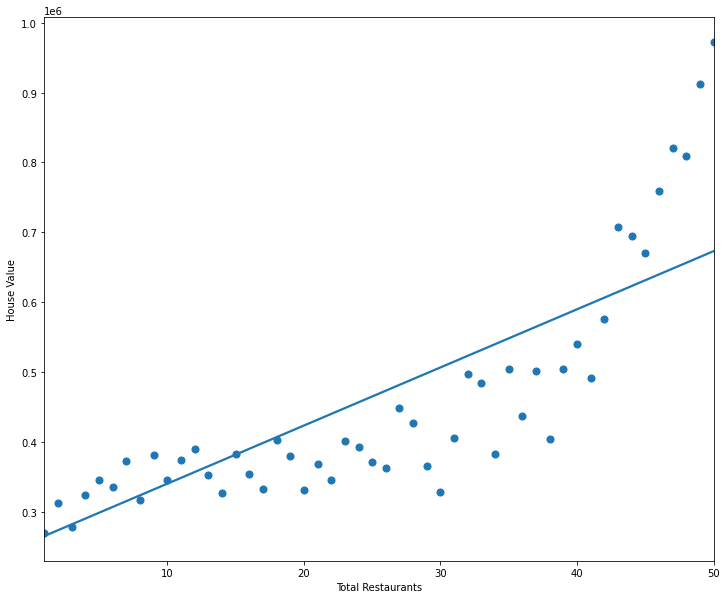

In [86]:
# first step we can plot a ses regression plot


fig, ax = plt.subplots(figsize=(12,10))

# plot fast food data agains price
sns.regplot(x='Total Restaurants', 
            y='House Value', 
            data=resturants_grouped,
            x_bins=1000,
            #x_jitter=0.7,
            order=1, 
            ci=None,
               ax=ax)
fig.savefig('house_res.png', bbox_inches='tight')

In [33]:
# y - is the same > house prices
# x - is now just one column of data, the total number of restaurants in each zipcide

x_sum = resturants_grouped["Total Restaurants"].to_numpy().reshape(-1, 1)
coeff_total_df, result = run_linear_reg(x_sum ,y, ['Total'])

Train size ((3688, 1), (3688,))
Test size ((1817, 1), (1817,))
intercept:  417.87958486984814
mean squared error(sqrt):  361.61671503111216
R**2;  0.10646684634273684
CV score;  -173045.15649448492


In [58]:
# run a polynomila regression and get the scores
poly_res = run_poly(x_sum ,y, order=5)

Train size ((3688, 1), (3688,))
Test size ((1817, 1), (1817,))
mean squared error(sqrt):  359.31692842591485
R**2;  0.11779597505675132
CV score;  -167246.37859330984
